In [1]:
import os
import pandas as pd
from mtqe.data.loaders import load_ced_test_data
from mtqe.utils.paths import EVAL_DIR, PREDICTIONS_DIR
from mtqe.utils.plots import create_confusion_matrix_plot
from mtqe.utils.language_pairs import LI_LANGUAGE_PAIRS_WMT_21_CED

In [2]:
EXPERIMENT_GROUP_NAME = 'train_monolingual_auth_data_calibrated'
DATA_SPLIT = 'test'
THRESHOLD_STRATEGY = 'extreme'
FILE_SUFFIX = 'median_results.csv'
CHART_NAME = 'Test calibrated'

In [3]:
eval_files = [os.path.join(EVAL_DIR, EXPERIMENT_GROUP_NAME, file) for file in os.listdir(os.path.join(EVAL_DIR, EXPERIMENT_GROUP_NAME)) if file.endswith(FILE_SUFFIX)]
enja_separate = False
if os.path.isdir(os.path.join(EVAL_DIR, EXPERIMENT_GROUP_NAME + '_enja')):
    eval_files.extend([os.path.join(EVAL_DIR, EXPERIMENT_GROUP_NAME + '_enja', file) for file in os.listdir(os.path.join(EVAL_DIR, EXPERIMENT_GROUP_NAME + '_enja')) if file.endswith(FILE_SUFFIX)])
    enja_separate = True
    

In [4]:
dfs = []
for file in eval_files:
    df = pd.read_csv(file)
    dfs.append(df)

df_meta_results = pd.concat(dfs)

In [5]:
df_meta_results = df_meta_results[(df_meta_results['threshold_strategy'] == THRESHOLD_STRATEGY) & (df_meta_results['split'] == DATA_SPLIT)]

In [6]:
# Get lists of data to create plot
preds = []
targets = []
titles = []
for lp in LI_LANGUAGE_PAIRS_WMT_21_CED:
    seed = df_meta_results[df_meta_results['language_pair']==lp].iloc[0]['seed']
    mcc = df_meta_results[df_meta_results['language_pair']==lp].iloc[0]['MCC']
    precision = df_meta_results[df_meta_results['language_pair']==lp].iloc[0]['precision']
    recall = df_meta_results[df_meta_results['language_pair']==lp].iloc[0]['recall']
    titles.append('Language pair:' + lp + '\nMCC:' + str(mcc.round(3)) + '\nPrecision:' + str(precision.round(3)) + '\nRecall:' + str(recall.round(3)))
    threshold = df_meta_results[df_meta_results['language_pair']==lp].iloc[0]['threshold']
    file_prefix = lp + '_' + DATA_SPLIT + '_0' # + '_' + str(seed) # + '_llm'
    if lp == 'en-ja' and enja_separate:
        folder = EXPERIMENT_GROUP_NAME + '_enja'
    else:
        folder = EXPERIMENT_GROUP_NAME
    for file in os.listdir(os.path.join(PREDICTIONS_DIR, 'ced_data', folder)):
        if file.startswith(file_prefix) and file.endswith('.csv'):
            # found predictions
            df_preds = pd.read_csv(os.path.join(PREDICTIONS_DIR, 'ced_data', folder, file))
            scores = df_preds['score'].to_numpy()
            scores = 1 - scores
            binary_scores = scores > threshold
            binary_scores = binary_scores.astype('int')
            preds.append(binary_scores)
    targets.append(1 - load_ced_test_data(lp)['score'].to_numpy())

print(len(preds))
print(len(targets))

4
4


In [7]:
df_meta_results[df_meta_results['language_pair']=='en-cs'].iloc[0]['seed']

'-'

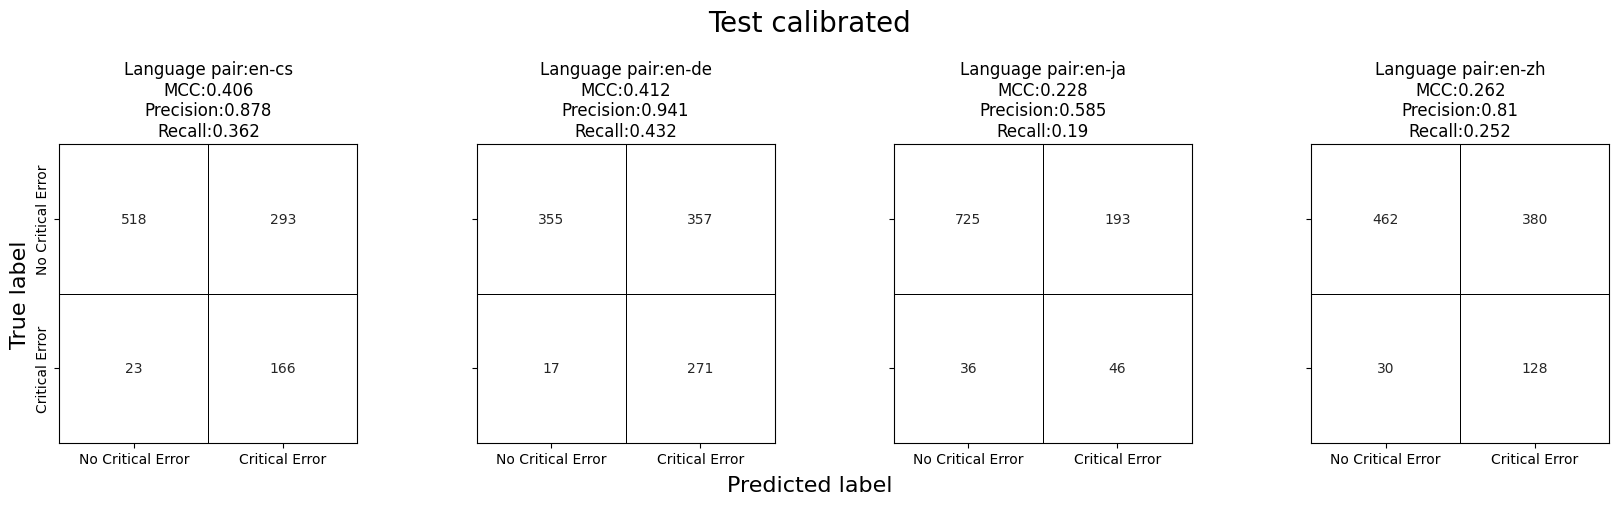

In [8]:
fig = create_confusion_matrix_plot(CHART_NAME, titles, preds, targets)